In [2]:
# public library imports
import pandas as pd
import os
import numpy as np
print("Current directory:", os.getcwd())
import sys
sys.path.append('.')
import torch
from collections import deque
from tqdm import tqdm
import os
import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import clear_output

# own imports  
from MDQN import ReplayBuffer, M_DQN_Agent
from Trading_Simulator import TradingEnvironment
from Residual_Generator import PCA
from Signal_Extractor import FourierExtractor, CNNTransformerExtractor, CumsumExtractor
from TD3 import ReplayBuffer_TD3, TD3


%reload_ext autoreload
%autoreload 2

Current directory: /Users/quintengeerts/Desktop/master thesis/stat_arb_thesis/empirical_analysis


In [4]:
# USE THE DATASET FROM WHARTON RESEARCH DATA SERVICES
filename = 'wrds_daily_returns.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[:dt.datetime(2021,12,31)]
price_df = price_df.replace(['C','B'],np.nan).astype(float)

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_5038/3220035147.py:4: DtypeWarning: Columns (21,41,83,93,98,103,118,155,161,171,196,197,236,243,248,253,266,274,278,288,312,330,346,372,409,422,434,439,449,464,470,487,489,490,494,495,506,524,539,549,550,581,583,611,615,616,618,630,634,635,662,710,725,726,728,729,732,742,751,760,769,782,785,794,817,818,834,838,880,881,923,937,960,1001,1002,1007,1022,1094,1112,1126,1151,1155,1171,1172,1177,1178,1179) have mixed types. Specify dtype option on import or set low_memory=False.
  price_df = pd.read_csv(filename)


In [2]:
# USE THE DATASET FROM eod.com
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

price_df = price_df.loc[dt.datetime(1998,1,1):].dropna(axis=0, thresh=300)

In [11]:
action_to_portfolio = {0:-1, 1:0, 2: 1}

### 1) Backwards test with fourier signal extractor -- MDQN

 Episode: 247 -- Annualized Return: 12.51% -- Annualized Volatility: 2.28% -- Annualized Sharpe: 5.49
 Episode: 247 -- Total ann. Return: 6.15% -- Total ann. Volatility: 2.91% -- Total ann. Sharpe: 2.11
Episode 248	Frame 6200 	Average Score: 0.00

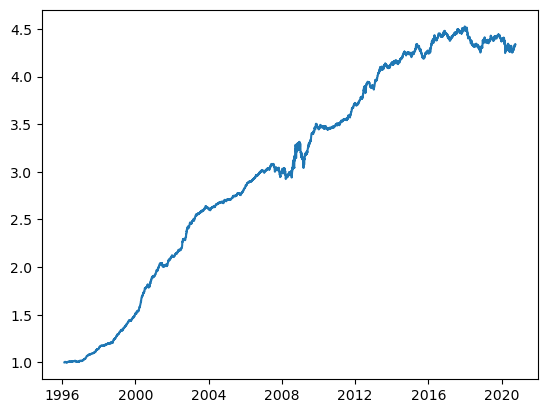

In [22]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [30]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=64,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25       # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

signal_extractor = FourierExtractor(signal_window=SIGNAL_WINDOW)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

In [23]:
env.total_pl.to_csv('results_pl.csv')
env.res_rets.to_csv('res_rets.csv')
env.res_alloc.to_csv('res_alloc.csv')

 Episode: 91 -- Annualized Return: -2.8% -- Annualized Volatility: 1.04% -- Annualized Sharpe: -2.68
 Episode: 91 -- Total ann. Return: -6.94% -- Total ann. Volatility: 1.87% -- Total ann. Sharpe: -3.72
Episode 92	Frame 2300 	Average Score: -0.00972

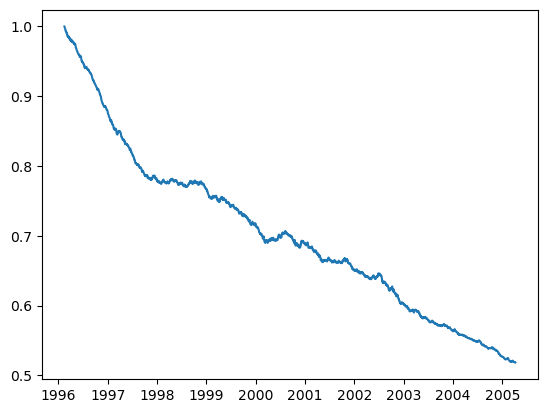

KeyboardInterrupt: 

In [90]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [30]
ALLOCATION_INCLUDED = True

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=30,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed,
                        add_alloc=ALLOCATION_INCLUDED)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 10        # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005    # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001    # cost of keeping a short position open
WARMUP_TIME     = 0         # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 250       # time before the feature extractor is retrained on new data
REBALANCE_FREQ  = 1

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        add_alloc=ALLOCATION_INCLUDED,
                        rebalance_every=REBALANCE_FREQ)

signal_extractor = FourierExtractor(add_alloc=ALLOCATION_INCLUDED, signal_window=SIGNAL_WINDOW)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning stepre
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date]) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features = signal_extractor.extract(features)

    score *= (reward.mean(axis=1).item() + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.5f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1

In [82]:
reward.mean(axis=1).item()

-0.00015476315546928275

In [ ]:
laatste allocatie toevoegen aan state!

/var/folders/qc/v9nsdlnj777f923zdc9n38vw0000gn/T/ipykernel_90687/1020766913.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


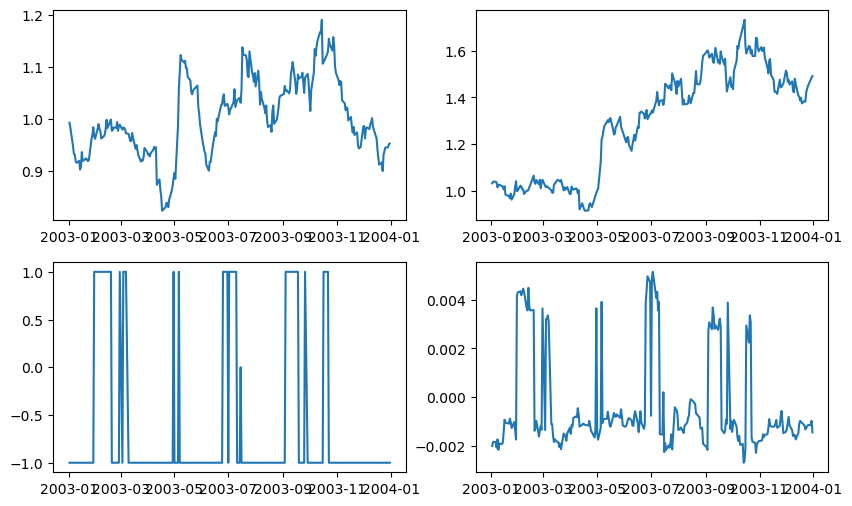

In [93]:
stock = 'AAPL'
begin = dt.datetime(2003,1,1)
end   = dt.datetime(2004,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock]+1).cumprod()
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)
fig.show()

In [ ]:
waarom allemaal dezelfde allocation?

### 2) Backward test with CNN+Transformer as signal extractor -- MDQN

 Episode: 243 -- Annualized Return: 6.88% -- Annualized Volatility: 1.83% -- Annualized Sharpe: 3.77
 Episode: 243 -- Total ann. Return: 4.47% -- Total ann. Volatility: 2.29% -- Total ann. Sharpe: 1.95


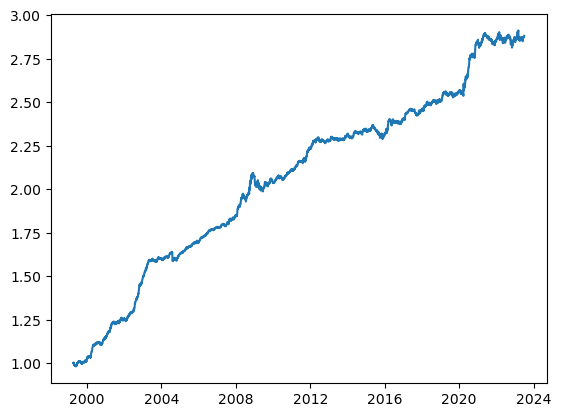

In [30]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [8]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=8,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed,
                        use_transf=False)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(signal_window=SIGNAL_WINDOW)


buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

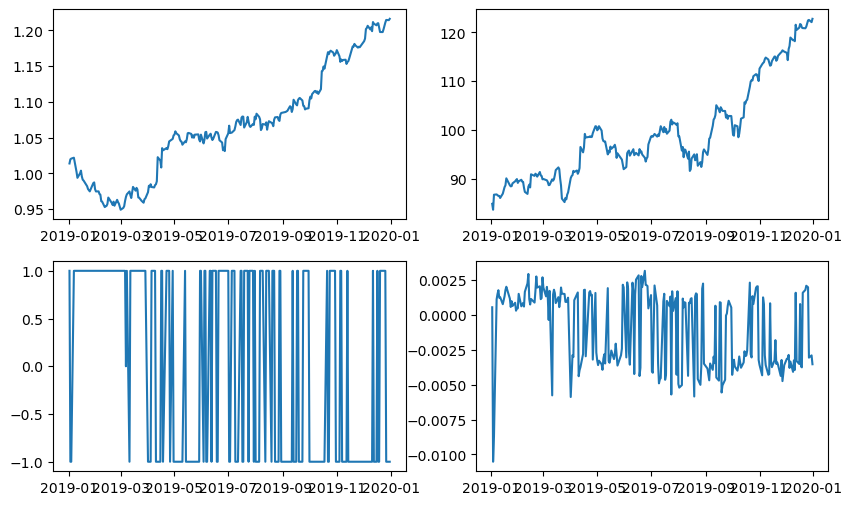

In [33]:
stock = 'JPM'
begin = dt.datetime(2019,1,1)
end   = dt.datetime(2020,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock])
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)


 Episode: 19 -- Annualized Return: -30.1% -- Annualized Volatility: 20.79% -- Annualized Sharpe: -1.45
 Episode: 19 -- Total ann. Return: -2.41% -- Total ann. Volatility: 10.07% -- Total ann. Sharpe: -0.24


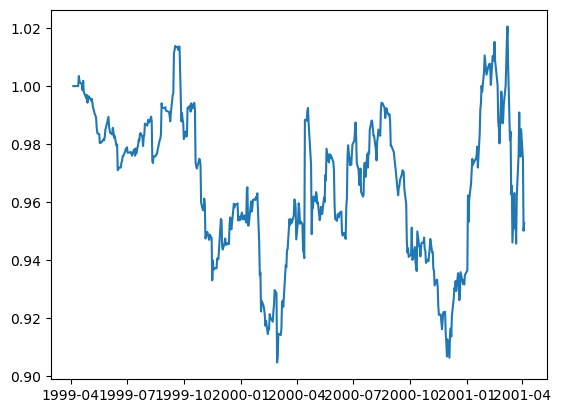

KeyboardInterrupt: 

In [79]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)

frames      = 6200
BUFFER_SIZE = 1000000
BATCH_SIZE  = 64
GAMMA       = 0.99
TAU         = 1e-2
eps_frames  = 500
min_eps     = 0.025
LR          = 1e-3
UPDATE_EVERY= 5
n_step      = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

action_size       = 3
state_size        = [8]

agent = M_DQN_Agent(state_size=state_size,    
                        action_size=action_size,
                        layer_size=16,
                        BATCH_SIZE=BATCH_SIZE, 
                        BUFFER_SIZE=BUFFER_SIZE, 
                        LR=LR, 
                        TAU=TAU, 
                        GAMMA=GAMMA, 
                        UPDATE_EVERY=UPDATE_EVERY, 
                        device=device, 
                        seed=seed,
                        use_transf=False)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 0         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        rebalance_every=10)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(signal_window=SIGNAL_WINDOW)


buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=GAMMA,
                                n_step=1,
                                cont_action_space=False)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):

    action = agent.act_para(features, eps)
    portfolio_allocations = np.vectorize(action_to_portfolio.get)(action) #actions need to be turned into allocations
    next_state, reward, done, info = env.step(portfolio_allocations.T)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], state[ticker].values, True)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[0,idx], reward[ticker].values[0], next_state[ticker].values, False)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            agent.learn(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

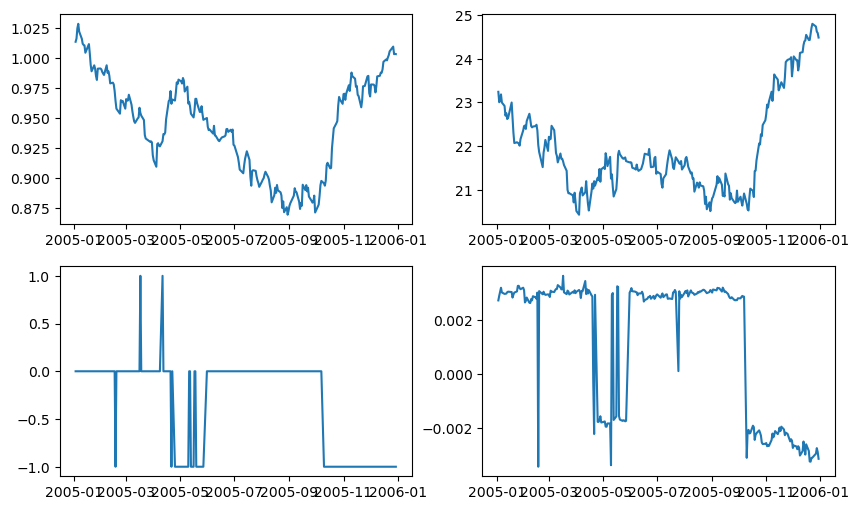

In [42]:
stock = 'JPM'
begin = dt.datetime(2005,1,1)
end   = dt.datetime(2006,1,1)
residual_test = (env.res_rets.loc[begin:end,stock]+1).cumprod()
alloc_test    = env.res_alloc.loc[begin:end,stock]
fig, ax  = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(residual_test)
ax[1,0].plot(alloc_test)

alloc_test    = env.asset_alloc.loc[begin:end,stock]
residual_test = (env.data.loc[begin:end,stock])
ax[0,1].plot(residual_test)
ax[1,1].plot(alloc_test)

In [43]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)

# Establish unique IDs to conform with package
N = len(np.unique(data.firm))
ID = dict(zip(np.unique(data.firm).tolist(),np.arange(1,N+1)))
data.firm = data.firm.apply(lambda x: ID[x])

In [165]:
import numpy as np
import pandas as pd
import datetime as dt
begin = dt.datetime(2000,1,1)
end   =  dt.datetime(2004,1,1)

data = pd.read_csv('monthly_IPCA_panel.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.date = pd.to_datetime(data.date)
data = data[(data.date > begin) & (data.date < end)].drop(['AC', 'DPI2A','OA','OL','OP','SGA2S'],axis=1)
data = data.set_index(['PERMNO', 'date'])
data = data.dropna(axis=0)

X = data[data.columns.difference(['TICKER', 'CUSIP', 'RET'])]
X = X.replace(['C','B'],np.nan).astype(float)
y = data['RET']
y = y.replace(['C','B'],np.nan).astype(float)

In [167]:
# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=5, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 511 , L: 32 , T: 48


[========================================================================] 100%


Step 1 - Aggregate Update: 2002245.7375001453
Step 2 - Aggregate Update: 1.5665077523907724
Step 3 - Aggregate Update: 5.554654489899945
Step 4 - Aggregate Update: 0.5820782401423767
Step 5 - Aggregate Update: 0.4242626926056856
Step 6 - Aggregate Update: 0.3043420843379039
Step 7 - Aggregate Update: 0.2074021113017388
Step 8 - Aggregate Update: 0.20159733889227172
Step 9 - Aggregate Update: 0.3126340023962494
Step 10 - Aggregate Update: 0.19754445098459916
Step 11 - Aggregate Update: 0.12788310126592584
Step 12 - Aggregate Update: 0.08778349290010579
Step 13 - Aggregate Update: 0.07383149943292802
Step 14 - Aggregate Update: 0.0729474577638154
Step 15 - Aggregate Update: 0.07203112997167782
Step 16 - Aggregate Update: 0.07192426204267367
Step 17 - Aggregate Update: 0.07178028872195392
Step 18 - Aggregate Update: 0.07011989770931187
Step 19 - Aggregate Update: 0.06734116028861309
Step 20 - Aggregate Update: 0.06372005996193256
Step 21 - Aggregate Update: 0.059467596041848925
Step 22 - 

In [185]:
data.TICKER.unique()

array(['ADCT', 'AES', 'AKS', 'T', 'ANF', 'ABMD', 'ADBE', 'DV', 'AMD',
       'AMG', 'A', 'APD', 'ARG', 'AKAM', 'ALK', 'ALB', 'ACV', 'ABS', 'AL',
       'ALXN', 'AYE', 'ATI', 'AGN', 'LNT', 'ALTR', 'MO', 'AZA', 'AMZN',
       'AEE', 'ACAS', 'AEP', 'AXP', 'AM', 'AIG', 'APCC', 'AMT', 'AAS',
       'ABC', 'AME', 'AMGN', 'APC', 'ADI', 'TSO', 'ANDW', 'ANSS', 'APA',
       'AAPL', 'PEB', 'ABI', 'AMAT', 'AMCC', 'ACK', 'ASH', 'AFS', 'ARC',
       'ATO', 'ADSK', 'AN', 'AZO', 'BMCS', 'BMC', 'BLL', 'ABX', 'BRL',
       'BSET', 'LTD', 'FO', 'BSC', 'BBBY', 'BMS', 'BKLY', 'BER', 'BBY',
       'BFO', 'CNS', 'BLI', 'BIO', 'BGEN', 'IDPH', 'BIIB', 'TECH', 'BDK',
       'BLK', 'BA', 'PCLN', 'BWA', 'BGG', 'BMY', 'BRCM', 'BVSN', 'BRO',
       'BC', 'BR', 'CBS', 'CHRW', 'CMS', 'CVS', 'CA', 'COG', 'CDN', 'COF',
       'CMX', 'CCL', 'CAT', 'CELG', 'REI', 'CNP', 'CTX', 'CEPH', 'CERN',
       'CHA', 'CRL', 'CHRS', 'CVX', 'CB', 'CHD', 'CIEN', 'CC', 'CSCO',
       'CTAS', 'CTXS', 'CLF', 'CTSH', 'CPQ', 'CPWR', 'CAG'

In [200]:
data[data.TICKER == 'BBBY'].tail(5)

TICKER     CUSIP      A2ME        AT       ATO      BEME  \
PERMNO date                                                                  
77659  2003-08-29   BBBY  07589610  0.201226  2309.971  1.070085  0.133676   
       2003-09-30   BBBY  07589610  0.180872  2309.971  1.070085  0.120155   
       2003-10-31   BBBY  07589610  0.219635  2488.945  1.389122  0.144948   
       2003-11-28   BBBY  07589610  0.199086  2488.945  1.389122  0.131387   
       2003-12-31   BBBY  07589610  0.197477  2488.945  1.389122  0.130325   

                          C        CF      CF2P       CTO  ...       S2P  \
PERMNO date                                                ...             
77659  2003-08-29  0.317938  0.044660  0.001723  0.386961  ...  0.077866   
       2003-09-30  0.317938  0.044660  0.001549  0.386961  ...  0.069990   
       2003-10-31  0.274273  0.053305  0.001807  0.446553  ...  0.098078   
       2003-11-28  0.274273  0.053305  0.001638  0.446553  ...  0.088902   
       2003-12-31  0.274273  0.053305  0.001625  0.446553  ...  0.088184   

                    MKTBETA  REL2HIGH      VOLA     r12_2     r12_7    r36_13  \
PERMNO date                                                                     
77659  2003-08-29  1.321140  0.886530  0.280046  0.210855  0.044916  0.765125   
       2003-09-30  1.318189  0.984703  0.240933  0.192201  0.014430  0.314439   
       2003-10-31  1.313556  0.873744  0.219941  0.216300 -0.025945  0.261792   
       2003-11-28  1.299163  0.963927  0.251947  0.103200  0.137792  0.703784   
       2003-12-31  1.297704  0.964384  0.260236  0.222705  0.210252  0.550391   

                        r2_1    RET_t_1        RET  
PERMNO date                                         
77659  2003-08-29  -0.071070   0.000258   0.110739  
       2003-09-30   0.000258   0.110739  -0.112683  
       2003-10-31   0.110739  -0.112683   0.103214  
       2003-11-28  -0.112683   0.103214   0.000474  
       2003-12-31   0.103214   0.000474   0.026278  

[5 rows x 35 columns]

In [187]:
test = pd.DataFrame(index=y.index,data=regr.predict(X=X), columns=['y_pred'])
test['y_real'] = y 

In [201]:
test_slice = test.loc[(77659, slice(None)),:]

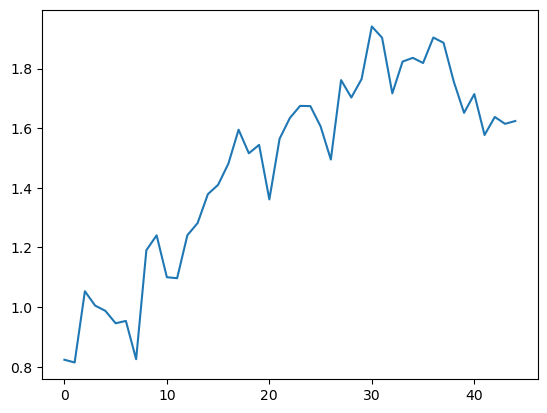

In [202]:
import matplotlib.pyplot as plt
plt.plot((test_slice.y_real - test_slice.y_pred + 1).cumprod().values)

In [44]:
# use multi-index for panel groups
data = data.set_index(['firm', 'year'])
y = data['invest']
X = data.drop('invest', axis=1)

In [51]:
# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=2, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 11 , L: 2 , T: 20
Step 1 - Aggregate Update: 991039.7089779959
Step 2 - Aggregate Update: 1.3877787807814457e-15
-- Convergence Reached --


### 3) Backward test with CNN+Transformer as signal extractor -- TD3

 Episode: 24 -- Annualized Return: -3.2% -- Annualized Volatility: 4.09% -- Annualized Sharpe: -0.78
 Episode: 24 -- Total ann. Return: -2.93% -- Total ann. Volatility: 1.85% -- Total ann. Sharpe: -1.59


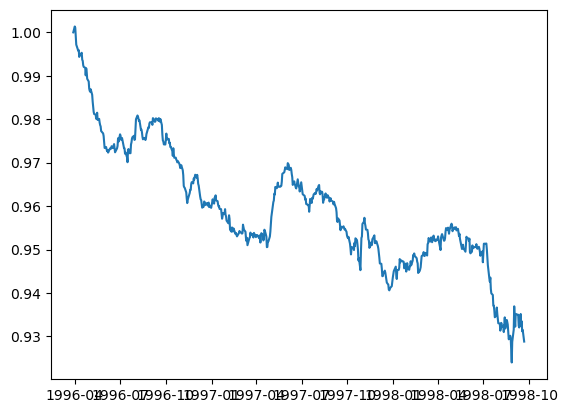

KeyboardInterrupt: 

In [10]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)
frames = 6200
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

HIDDEN_DIM      = 16 #[8,8,4,4] #16
BUFFER_SIZE     = 1000000
UPDATE_EVERY    = 5
POLICY_NOISE    =  0.2 # Noise added to target policy during critic update
MAX_ACTION      = 1
POLICY_FREQ     = 2 # Frequency of delayed policy updates
EXPL_NOISE      = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 50  #25e3 # Time steps initial random policy is used
NOISE_CLIP      = 0.5 # Range to clip target policy noise
BATCH_SIZE      = 64  # Batch size for both actor and critic
EVAL_FREQ       = 5e3  # How often (time steps) we evaluate

state_dim = 9 # env.observation_space.shape[0]
action_dim = 1
max_action = 1
USE_ALLOC       = True


kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
kwargs["use_alloc"]    = False #USE_ALLOC

policy = TD3(**kwargs)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 60        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005       # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001       # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        rebalance_every=1,
                        add_alloc=USE_ALLOC)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=alpha,
                                n_step=1,
                                cont_action_space=True)

#signal_extractor = CumsumExtractor(signal_window=SIGNAL_WINDOW)
signal_extractor = CNNTransformerExtractor(add_alloc=USE_ALLOC, signal_window=SIGNAL_WINDOW)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):
    # Select action randomly or according to policy
    if frame < START_TIMESTEPS:
        action = np.random.uniform(-1,1,(sum(env.tradeables),1))
    else:
        action = (
            policy.select_multiple_action(features)
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=(sum(env.tradeables),1))
        ).clip(-max_action, max_action)
    
    next_state, reward, done, info = env.step(action)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], state[ticker].values, False)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], next_state[ticker].values, True)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            policy.train(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 

### 3) Backward test with Fourier transform as signal extractor -- TD3

 Episode: 21 -- Annualized Return: -0.73% -- Annualized Volatility: 1.87% -- Annualized Sharpe: -0.39
 Episode: 21 -- Total ann. Return: -3.85% -- Total ann. Volatility: 2.77% -- Total ann. Sharpe: -1.39


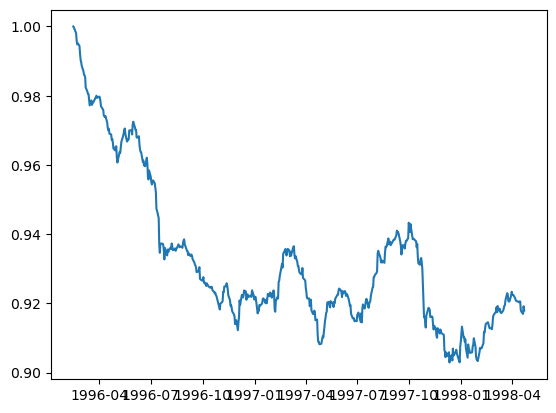

KeyboardInterrupt: 

In [16]:
# PARAMETERS
seed = 100  #np.random.randint(0,100000)
frames = 6200
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

USE_ALLOC       = True
HIDDEN_DIM      = [16,8,4,4] #64
BUFFER_SIZE     = 1000000
UPDATE_EVERY    = 1
POLICY_NOISE    = 0.2 # Noise added to target policy during critic update
MAX_ACTION      = 1
POLICY_FREQ     = 2 # Frequency of delayed policy updates
EXPL_NOISE      = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 50  #25e3 # Time steps initial random policy is used
NOISE_CLIP      = 0.5 # Range to clip target policy noise
BATCH_SIZE      = 64  # Batch size for both actor and critic
EVAL_FREQ       = 5e3  # How often (time steps) we evaluate

state_dim = 30  #30 # env.observation_space.shape[0]
action_dim = 1
max_action = 1

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = False
file_name = 'N1'

# Set seeds
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"]   = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"]  = POLICY_FREQ
kwargs["use_alloc"]    = USE_ALLOC
policy = TD3(**kwargs)

##########################

MINIMUM_BUFFER  = 5000      # minimum amount of experiences before the DRL agent starts learning
EPISODE_LENGTH  = 25        # episode length, only used for telling when to show the performance
LOOKBACK_WINDOW = 252       # lookback window used for the PCA estimation
LOADING_WINDOW  = 60        # last 30 values are used to create the loadings for the factor model
FACTORS         = 5         # the amount of factors used in the factor model
SIGNAL_WINDOW   = 30        # the length of the window used for extracting the signal
TRANS_COST      = 0.0005    # transaction cost for changes in the portfolio
SHORT_COST      = 0.0001    # cost of keeping a short position open

WARMUP_TIME     = 100       # time needed to run the factor models before starting the strategy
RETRAIN_EVERY   = 5         # time before the feature extractor is retrained on new data
BATCH_SIZE_EXTR = 5

env = TradingEnvironment(financial_dataset=price_df.dropna(axis=0, thresh=300),
                        residual_generator=PCA,
                        episode_length=EPISODE_LENGTH,
                        lookback_window=LOOKBACK_WINDOW,
                        loading_window=LOADING_WINDOW,
                        signal_window=SIGNAL_WINDOW,
                        factors=FACTORS,
                        transaction_costs=TRANS_COST,
                        short_cost=SHORT_COST,
                        rebalance_every=1,
                        add_alloc=USE_ALLOC)

buffer           = ReplayBuffer(buffer_size=BUFFER_SIZE,
                                batch_size=BATCH_SIZE,
                                device=device,
                                seed=seed,
                                gamma=alpha,
                                n_step=1,
                                cont_action_space=True)

signal_extractor = FourierExtractor(add_alloc=USE_ALLOC, signal_window=SIGNAL_WINDOW)

state, _ = env.warm_up(warmup_time=WARMUP_TIME)
signal_extractor.train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date])
features = state[env.tradeable_tickers].values.T # turns the dataframe for the requested tickers into a ndarray
features = signal_extractor.extract(features)

# INITIALISING SOME VARIABLES
score = 1
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1

#training loop
for frame in range(1, frames+1-WARMUP_TIME):
    # Select action randomly or according to policy
    if frame < START_TIMESTEPS:
        action = np.random.uniform(-1,1,(sum(env.tradeables),1))
    else:
        action = (
            policy.select_multiple_action(features)
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=(sum(env.tradeables),1))
        ).clip(-max_action, max_action)
    
    next_state, reward, done, info = env.step(action)
    
    # ADD TO BUFFER 
    for idx, ticker in enumerate(env.old_tradeable_tickers):
        if done[ticker].values[0]:
            # if the ticker is removed from the tradeable tickers, done = true and new_state is the last one
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], state[ticker].values, False)
        else:
            # if the ticker is not removed from the tradeable tickers, done = false 
            buffer.add(state[ticker].values, action[idx,0], reward[ticker].values[0], next_state[ticker].values, True)

        # DEEP REINFORCEMENT LEARNING UPDATE
        if len(buffer) > MINIMUM_BUFFER and idx % UPDATE_EVERY == 0:
            experiences = buffer.sample()
            # extract the features using the current feature extractor
            states_buffer, actions_buffer, rewards_buffer, next_states_buffer, dones_buffer = experiences
            features_buffer      = torch.FloatTensor(signal_extractor.extract(states_buffer))
            next_features_buffer = torch.FloatTensor(signal_extractor.extract(next_states_buffer))
            experiences          = (features_buffer, actions_buffer, rewards_buffer, next_features_buffer, dones_buffer)
            # perform a learning step
            policy.train(experiences)

    # FEATURE EXTRACTOR RETRAINING
    if frame % RETRAIN_EVERY == 0:
        signal_extractor.re_train(train_data = env.res_rets.loc[env.date - dt.timedelta(days=WARMUP_TIME):env.date],
                                  sample_size = BATCH_SIZE_EXTR) 
    
    state     = next_state
    features  = next_state[env.tradeable_tickers].values.T
    features  = signal_extractor.extract(features)

    score *= (env.p_l + 1)
    
    if frame % EPISODE_LENGTH == 0:
        scores_window.append(score-1)       # save most recent score
        scores.append(score-1)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        clear_output(True)
        env.evaluate_performance()
        plt.plot((env.total_pl.dropna() + 1).cumprod())
        plt.show()
        i_episode +=1 
        score = 1 